In [ ]:
pip install kagglehub

In [ ]:
import kagglehub
import os
import shutil
import random

# Define the name of the Kaggle dataset
dataset_name = "abdallahalidev/plantvillage-dataset"

# Define the root directory where the dataset will be downloaded
download_root = "./plantvillage_dataset"

# Define the names for the train, test, and val directories
train_dir = os.path.join(download_root, "train")
test_dir = os.path.join(download_root, "test")
val_dir = os.path.join(download_root, "val")

# Define the train-test split ratio (8:2)
train_ratio = 0.8
test_ratio = 0.2

# Download the latest version of the dataset
try:
    path = kagglehub.dataset_download(dataset_name, path=download_root, force=True)
    print("Path to downloaded dataset files:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    exit()

# Assuming the downloaded files are in a single directory or a structure
# that needs to be organized. We'll look for subdirectories within the
# downloaded structure, assuming each subdirectory represents a class.

# Find subdirectories (assuming they represent plant disease classes)
dataset_base_dir = ""
for item in os.listdir(download_root):
    item_path = os.path.join(download_root, item)
    if os.path.isdir(item_path):
        # Assuming the first subdirectory found is the base for the images
        dataset_base_dir = item_path
        break
else:
    print("No subdirectories found in the downloaded dataset to organize.")
    exit()

# Create train, test, and val directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get a list of all subdirectories (classes) within the dataset base directory
class_names = [item for item in os.listdir(dataset_base_dir) if os.path.isdir(os.path.join(dataset_base_dir, item))]

print("Found the following classes:", class_names)

# Iterate through each class and split the images into train, test, and val
for class_name in class_names:
    class_path = os.path.join(dataset_base_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    num_images = len(images)
    train_split = int(train_ratio * num_images)
    test_split = int(test_ratio * num_images)

    train_images = images[:train_split]
    test_images = images[train_split:train_split + test_split]
    val_images = images[train_split + test_split:]

    # Create class-specific subdirectories in train, test, and val
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Move images to their respective directories
    for image in train_images:
        src_path = os.path.join(class_path, image)
        dst_path = os.path.join(train_dir, class_name, image)
        shutil.copy2(src_path, dst_path)  # copy2 preserves metadata
    print(f"Moved {len(train_images)} images to train/{class_name}")

    for image in test_images:
        src_path = os.path.join(class_path, image)
        dst_path = os.path.join(test_dir, class_name, image)
        shutil.copy2(src_path, dst_path)
    print(f"Moved {len(test_images)} images to test/{class_name}")

    for image in val_images:
        src_path = os.path.join(class_path, image)
        dst_path = os.path.join(val_dir, class_name, image)
        shutil.copy2(src_path, dst_path)
    print(f"Moved {len(val_images)} images to val/{class_name}")

print("Dataset organization into train, test, and val folders complete.")
print("Train directory:", train_dir)
print("Test directory:", test_dir)
print("Validation directory:", val_dir)

In [1]:
pip install split-folders


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(38,activation='softmax')(x) #final layer with softmax activation

17227776/17225924 [==============================] - 0s 0us/step


In [4]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [5]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [6]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio('../input/plantvillage-dataset/segmented', output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 54306 files [06:45, 134.05 files/s]


In [7]:

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./output/train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 43430 images belonging to 38 classes.


In [8]:
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=train_datagen.flow_from_directory('./output/val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 10876 images belonging to 38 classes.


In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
accident_model=model.fit_generator(generator=train_generator,
                    validation_data =val_generator,
                   steps_per_epoch=step_size_train,
                   
                   epochs=5)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1357/1357 [==============================] - 139s 99ms/step - loss: 0.7514 - accuracy: 0.7884 - val_loss: 0.5736 - val_accuracy: 0.8577
Epoch 2/5
1357/1357 [==============================] - 133s 98ms/step - loss: 0.2371 - accuracy: 0.9343 - val_loss: 0.1807 - val_accuracy: 0.9477
Epoch 3/5
1357/1357 [==============================] - 133s 98ms/step - loss: 0.1793 - accuracy: 0.9496 - val_loss: 0.2329 - val_accuracy: 0.9320
Epoch 4/5
1357/1357 [==============================] - 132s 97ms/step - loss: 0.1464 - accuracy: 0.9599 - val_loss: 0.4198 - val_accuracy: 0.8977
Epoch 5/5
1357/1357 [==============================] - 134s 99ms/step - loss: 0.1321 - accuracy: 0.9645 - val_loss: 0.1223 - val_accuracy: 0.9674


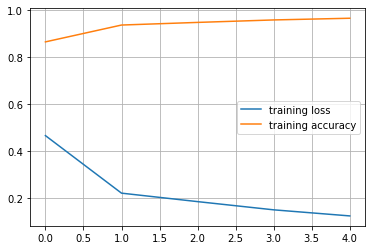

In [10]:
plt.plot(accident_model.history['loss'], label = 'training loss')
plt.plot(accident_model.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

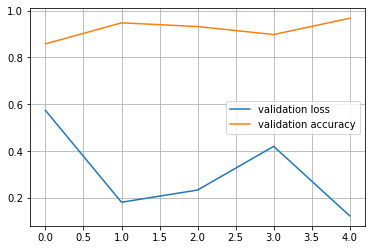

In [11]:
plt.plot(accident_model.history['val_loss'], label = 'validation loss')
plt.plot(accident_model.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [12]:
from keras.models import load_model 
model.save("network.h5") 

In [13]:
from keras.models import load_model 


In [14]:
model = load_model('network.h5')
# summarize model.
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     